In [1]:
import csv
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn import preprocessing
from catboost import CatBoostRegressor, CatBoostClassifier, Pool
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

In [2]:
data_path = os.path.abspath('.') + '/../data/'
train = pd.read_csv(data_path + "train.csv")
test = pd.read_csv(data_path + "test.csv")
sample_submission = pd.read_csv(data_path + "sample_submission.csv")

In [3]:
id_list = test['ID_LAT_LON_YEAR_WEEK']
test.head()

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,...,Cloud_cloud_top_pressure,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle
0,ID_-0.510_29.290_2022_00,-0.51,29.29,2022,0,NaN,NaN,NaN,NaN,NaN,...,36022.027344,8472.313477,41047.937500,7472.313477,7.935617,0.240773,-100.113792,33.697044,-133.047546,33.779583
1,ID_-0.510_29.290_2022_01,-0.51,29.29,2022,1,0.000456,0.691164,0.000316,0.000000,76.239196,...,48539.737242,6476.147323,54915.708579,5476.147161,11.448437,0.293119,-30.510319,42.402593,-138.632822,31.012380
2,ID_-0.510_29.290_2022_02,-0.51,29.29,2022,2,0.000161,0.605107,0.000106,0.079870,-42.055341,...,34133.080469,8984.795703,39006.093750,7984.795703,10.753179,0.267130,39.087361,45.936480,-144.784988,26.743361
3,ID_-0.510_29.290_2022_03,-0.51,29.29,2022,3,0.000350,0.696917,0.000243,0.201028,72.169566,...,50854.991076,6014.724059,57646.368368,5014.724115,11.764556,0.304679,-24.465127,42.140419,-135.027891,29.604774
4,ID_-0.510_29.290_2022_04,-0.51,29.29,2022,4,-0.000317,0.580527,-0.000184,0.204352,76.190865,...,46594.685145,6849.280477,52896.541873,5849.280394,13.065317,0.284221,-12.907850,30.122641,-135.500119,26.276807


In [4]:
train.head()

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,...,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,emission
0,ID_-0.510_29.290_2019_00,-0.51,29.29,2019,0,-0.000108,0.603019,-0.000065,0.255668,-98.593887,...,3664.436218,61085.809570,2615.120483,15.568533,0.272292,-12.628986,35.632416,-138.786423,30.752140,3.750994
1,ID_-0.510_29.290_2019_01,-0.51,29.29,2019,1,0.000021,0.728214,0.000014,0.130988,16.592861,...,3651.190311,66969.478735,3174.572424,8.690601,0.256830,30.359375,39.557633,-145.183930,27.251779,4.025176
2,ID_-0.510_29.290_2019_02,-0.51,29.29,2019,2,0.000514,0.748199,0.000385,0.110018,72.795837,...,4216.986492,60068.894448,3516.282669,21.103410,0.251101,15.377883,30.401823,-142.519545,26.193296,4.231381
3,ID_-0.510_29.290_2019_03,-0.51,29.29,2019,3,NaN,NaN,NaN,NaN,NaN,...,5228.507736,51064.547339,4180.973322,15.386899,0.262043,-11.293399,24.380357,-132.665828,28.829155,4.305286
4,ID_-0.510_29.290_2019_04,-0.51,29.29,2019,4,-0.000079,0.676296,-0.000048,0.121164,4.121269,...,3980.598120,63751.125781,3355.710107,8.114694,0.235847,38.532263,37.392979,-141.509805,22.204612,4.347317


In [5]:
train.shape, test.shape, sample_submission.shape

((79023, 76), (24353, 75), (24353, 2))

In [6]:
# latitude和longitude是重要特征。
train = train.loc[:,["latitude", "longitude", "year", "week_no", "emission"]]
test = test.loc[:,["latitude", "longitude", "year", "week_no"]]

In [7]:
# K-Means聚类
k_model = KMeans(n_clusters=6)
train_x = train.groupby(by=['latitude', 'longitude'], as_index=False)['emission'].mean()
k_model.fit(train_x)
k_Means = k_model.predict(train_x)
train_x['k_Means'] = k_Means

train = train.merge(train_x[['latitude', 'longitude', 'k_Means']], on=['latitude', 'longitude'])
test = test.merge(train_x[['latitude', 'longitude', 'k_Means']], on=['latitude', 'longitude'])

train

C:\Users\Desert_Eagle\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,latitude,longitude,year,week_no,emission,k_Means
0,-0.510,29.290,2019,0,3.750994,2
1,-0.510,29.290,2019,1,4.025176,2
2,-0.510,29.290,2019,2,4.231381,2
3,-0.510,29.290,2019,3,4.305286,2
4,-0.510,29.290,2019,4,4.347317,2
...,...,...,...,...,...,...
79018,-3.299,30.301,2021,48,29.404171,2
79019,-3.299,30.301,2021,49,29.186497,2
79020,-3.299,30.301,2021,50,29.131205,2
79021,-3.299,30.301,2021,51,28.125792,2


Predict 2022

In [8]:
cat_params = {
    
    'n_estimators': 799, 
    'learning_rate': 0.09180872710592884,
    'depth': 8, 
    'l2_leaf_reg': 1.0242996861886846, 
    'subsample': 0.38227256755249117, 
    'colsample_bylevel': 0.7183481537623551,
    'random_state': 42,
    "silent": True,
}

clusters = train["k_Means"].unique()

for i in clusters:
    train_c = train[train["k_Means"] == i]
    test_c = test[test["k_Means"] == i].drop(columns = ["k_Means"])
    X = train_c.drop(columns = ["emission", "k_Means"])
    y = train_c["emission"].copy()

    catboost_reg = CatBoostRegressor(**cat_params)
    catboost_reg.fit(X, y)
    catboost_pred = catboost_reg.predict(test_c)

    test.loc[test["k_Means"] == i, "emission"] = catboost_pred
    
test

,latitude,longitude,year,week_no,k_Means,emission
0,-0.510,29.290,2022,0,2,2.553808
1,-0.510,29.290,2022,1,2,3.829513
2,-0.510,29.290,2022,2,2,4.175157
3,-0.510,29.290,2022,3,2,4.241419
4,-0.510,29.290,2022,4,2,4.470658
...,...,...,...,...,...,...
24348,-3.299,30.301,2022,44,2,29.494484
24349,-3.299,30.301,2022,45,2,29.555080
24350,-3.299,30.301,2022,46,2,29.678273
24351,-3.299,30.301,2022,47,2,30.142149


In [9]:
test['ID_LAT_LON_YEAR_WEEK'] = id_list
CatBoostRegressor = test.loc[:,["ID_LAT_LON_YEAR_WEEK", "emission"]]
CatBoostRegressor.to_csv(data_path + "submission.csv", index=False)

In [10]:
zero_emissions = train.groupby(['latitude', 'longitude'])['emission'].mean().to_frame()
zero_emissions = zero_emissions[zero_emissions['emission'] == 0]
CatBoostRegressor[CatBoostRegressor['emission'] < 0] = 0
mask = test.apply(lambda x: (x['latitude'], x['longitude']) in zero_emissions.index, axis=1)
CatBoostRegressor[mask] = 0

计算分数

In [11]:
from sklearn.metrics import mean_squared_error
actual1 = pd.read_csv("../Examples/Rwanda_CO2_Step_by_step_guide/submission_23.35768.csv")
actual2 = pd.read_csv("../Examples/submission_9.43672.csv")
actual3 = pd.read_csv("../Examples/submission_12.74114.csv")
actual4 = pd.read_csv("../Examples/submission_private_8.77676.csv")

In [12]:
rmse = mean_squared_error(actual2["emission"], CatBoostRegressor["emission"], squared=False)
rmse

11.698490872673576

RadiusNeighborsRegressor

In [13]:
from sklearn.neighbors import RadiusNeighborsRegressor
model = RadiusNeighborsRegressor(radius=0) # or DecisionTreeRegressor()
model.fit(train[['longitude', 'latitude', 'week_no']], train.emission)
y_pred = model.predict(test[['longitude', 'latitude', 'week_no']])
RadiusNeighbors = sample_submission.copy()
RadiusNeighbors['emission'] = y_pred 
# RadiusNeighbors *= 1.075
RadiusNeighbors['emission'] *= 1.1

zero_emissions = train.groupby(['latitude', 'longitude'])['emission'].mean().to_frame()
zero_emissions = zero_emissions[zero_emissions['emission'] == 0]
RadiusNeighbors[RadiusNeighbors['emission'] < 0] = 0
mask = test.apply(lambda x: (x['latitude'], x['longitude']) in zero_emissions.index, axis=1)
RadiusNeighbors[mask] = 0

RadiusNeighbors.to_csv(data_path + "submission_RadiusNeighborsRegressor.csv")
rmse = mean_squared_error(actual2["emission"], RadiusNeighbors['emission'], squared=False)
rmse

15.071266062185737

KNeighborsRegressor

In [14]:
from sklearn.neighbors import KNeighborsRegressor
model = KNeighborsRegressor(n_neighbors=3)
model.fit(train[['longitude', 'latitude', 'week_no']], train.emission)
y_pred = model.predict(test[['longitude', 'latitude', 'week_no']])
KNeighbors = sample_submission.copy()
KNeighbors['emission'] = y_pred
KNeighbors['emission'] *= 1.1

zero_emissions = train.groupby(['latitude', 'longitude'])['emission'].mean().to_frame()
zero_emissions = zero_emissions[zero_emissions['emission'] == 0]
KNeighbors[KNeighbors['emission'] < 0] = 0
mask = test.apply(lambda x: (x['latitude'], x['longitude']) in zero_emissions.index, axis=1)
KNeighbors[mask] = 0

KNeighbors.to_csv(data_path + "submission_KNeighborsRegressor.csv")
rmse = mean_squared_error(actual2["emission"], KNeighbors['emission'], squared=False)
rmse

15.071266062185737

RandomForestRegressor

In [15]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(min_samples_leaf=6)
model.fit(train[['longitude', 'latitude', 'week_no']], train.emission)
y_pred = model.predict(test[['longitude', 'latitude', 'week_no']])
RandomForest = sample_submission.copy()
RandomForest['emission'] = y_pred
RandomForest['emission'] *= 1.1

zero_emissions = train.groupby(['latitude', 'longitude'])['emission'].mean().to_frame()
zero_emissions = zero_emissions[zero_emissions['emission'] == 0]
RandomForest[RandomForest['emission'] < 0] = 0
mask = test.apply(lambda x: (x['latitude'], x['longitude']) in zero_emissions.index, axis=1)
RandomForest[mask] = 0

RandomForest.to_csv(data_path + "submission_RandomForestRegressor.csv")
rmse = mean_squared_error(actual2["emission"], RandomForest['emission'], squared=False)
rmse

15.424598922032661

Pearson correlation: -0.013960940599134839
Spearman correlation: -0.06904123013729443


d:\Anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


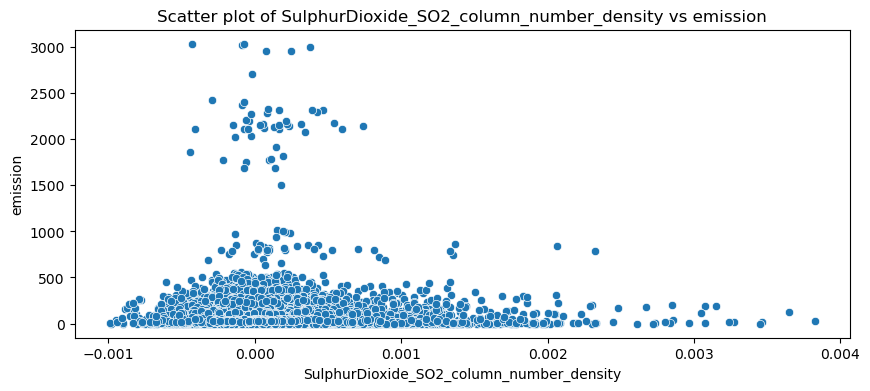

                            OLS Regression Results                            
Dep. Variable:               emission   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     4.144
Date:                Fri, 15 Dec 2023   Prob (F-statistic):             0.0418
Time:                        09:02:12   Log-Likelihood:            -1.3450e+05
No. Observations:               21260   AIC:                         2.690e+05
Df Residuals:                   21258   BIC:                         2.690e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

In [21]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
import statsmodels.api as sm

# 加载数据
data_path = os.path.abspath('.') + '/../data/'
df = pd.read_csv(data_path + "train.csv")
# df = df[(df['latitude'] == -2.378) & (df['longitude'] == 29.222)]
col = "SulphurDioxide_SO2_column_number_density"
# for col in df.columns:
try:
    df = df[df['year'] == 2020]
    df = df.dropna(subset=[col, 'emission'])

    # 计算相关系数
    pearson_corr, _ = pearsonr(df[col], df['emission'])
    spearman_corr, _ = spearmanr(df[col], df['emission'])
    # if pearson_corr < 0.4:
    #     continue
    print(f'Pearson correlation: {pearson_corr}')
    print(f'Spearman correlation: {spearman_corr}')
except:
    pass

# 绘制散点图
plt.figure(figsize=(10, 4))
sns.scatterplot(x=col, y='emission', data=df)
plt.title('Scatter plot of ' + col + ' vs emission')
plt.show()

# 进行回归分析
X = sm.add_constant(df[col])
model = sm.OLS(df['emission'], X)
results = model.fit()
print(results.summary())

In [17]:
df = pd.read_csv(data_path + "train.csv")
missing=df.isnull().sum()
missing=missing.sort_values(ascending=False)
missing

UvAerosolLayerHeight_aerosol_height          78584
UvAerosolLayerHeight_solar_zenith_angle      78584
UvAerosolLayerHeight_solar_azimuth_angle     78584
UvAerosolLayerHeight_sensor_azimuth_angle    78584
UvAerosolLayerHeight_aerosol_pressure        78584
                                             ...  
latitude                                         0
week_no                                          0
year                                             0
longitude                                        0
emission                                         0
Length: 76, dtype: int64

In [32]:
pd.set_option('display.max_rows', 100)

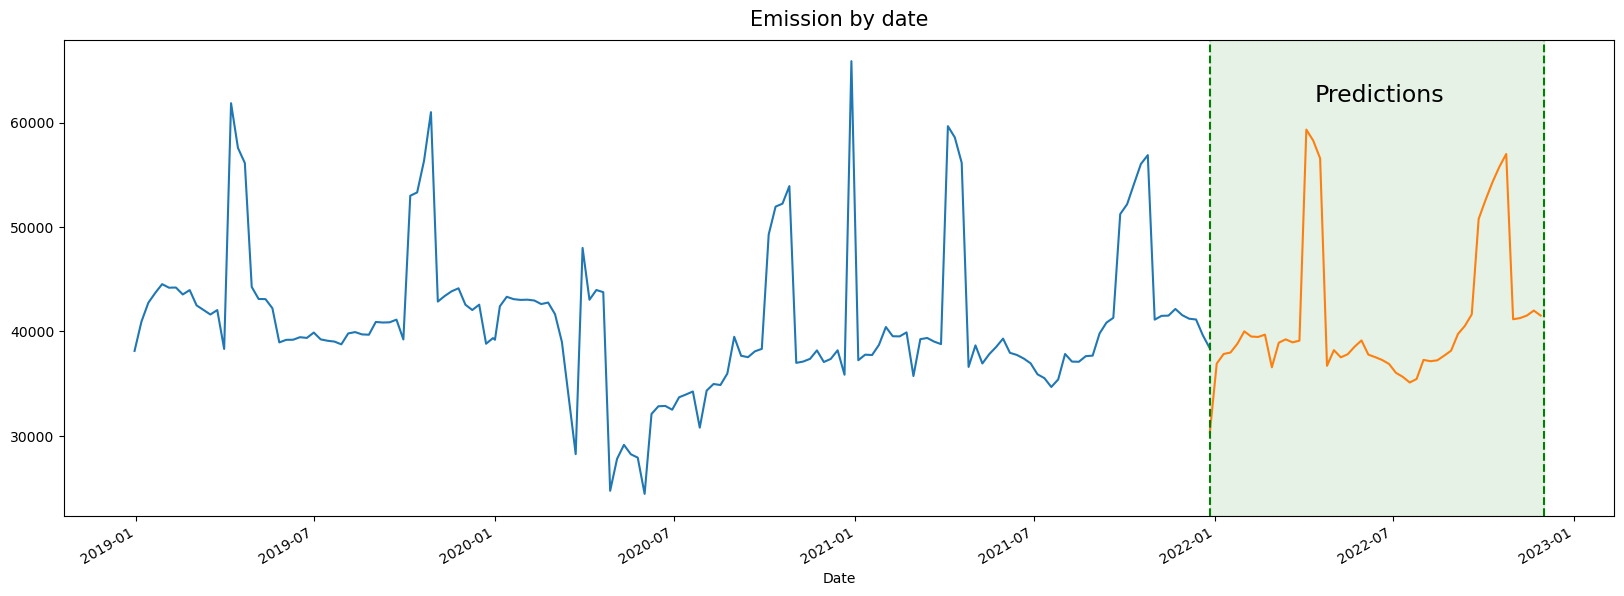

In [44]:
train_plot = pd.read_csv(data_path + "train.csv")
train_plot['date'] = pd.to_datetime(train_plot['year'].astype(str) + '-' + train_plot['week_no'].astype(str) + '-1', format='%Y-%W-%w') # 1 is a monday and %w day of week otherwise throws error
pred_plot = test.copy()
pred_plot['date'] = pd.to_datetime(pred_plot['year'].astype(str) + '-' + pred_plot['week_no'].astype(str) + '-1', format='%Y-%W-%w')
train_plot.groupby(['date'])['emission'].sum().plot(kind='line', figsize=(20, 7), xlabel='Date')
pred_plot.groupby(['date'])['emission'].sum().plot(kind='line', figsize=(20, 7), xlabel='Date')

plt.axvspan(pd.Timestamp('2021-12-27'), pd.Timestamp('2022-12-01'), color='green', alpha=0.1)
plt.axvline(pd.Timestamp('2021-12-27'), linestyle = "--", color='green')
plt.axvline(pd.Timestamp('2022-12-01'), linestyle = "--", color='green')

plt.text(pd.Timestamp ('2022-04-12'), 62000, "Predictions", size = 17)

plt.title('Emission by date', size=15, pad=10)
plt.show()